In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# 架構:
1. 前言可以放整體基金市場概況(總額，旁編列各各項商品)
2. 接著直接秀各產品概況，然後再秀同樣y軸scale的，說先講前幾大的

# 可延伸內容:
* 看受益人數變動?
* 配息?
* 風險等級?(TEJ抓資料看分布)→或許看想講的部分即可，看單一年

# 備註:
* AI, AH不存在於類別中(因年份編碼問題)
* 組合型為fund of fund

# 放QR code給大家掃看圖

In [2]:
category_index = pd.read_excel('類型代號說明.xlsx', '網頁版')
category_dict = dict(category_index.iloc[:, :2].values)
category_index.head(1)

,類別代號,中文名稱,英文名稱,說明
0,AA1,國內投資股票型,Domestic Equity Fund,NaN


In [3]:
data = pd.read_csv('data.csv',thousands=',')

# drop nan
data = data[data.類型代號.isna() != True]

# 處理AI, AH代碼問題
data.loc[data[data.基金統編 == '99346928'].index, '類型代號'] = 'AI1'
data.loc[data[data.基金統編 == '25591306'].index, '類型代號'] = 'AI2'
data.loc[data[data.基金統編 == '25610486'].index, '類型代號'] = 'AH2'
data.loc[data.基金統編.isin(data[data.類型代號 == 'AH'].基金統編.unique()), '類型代號'] = 'AH1'

def transform_key(x):
    try:
        return category_dict[x]
    except:
        pass

# 轉換代碼
data['基金類型'] = data.類型代號.apply(lambda x: transform_key(x))

# 剔除沒有基金類型者(各家每年總和值)
data = data[data.基金類型.isna() != True]

# 轉換年分
data.年分 = data.年分.apply(lambda x: datetime.strptime(str(x)[:4]+'/12/31', '%Y/%m/%d'))

# 存year index
year_index = np.arange(2008, 2019, 1)

In [4]:
category_index = pd.read_excel('類型代號說明.xlsx', '網頁版')
category_dict = dict(category_index.iloc[:, :2].values)
category_index.head(1)

# 建立大分類
main_category = dict({
    '股票型': set(['AA1', 'AA2']),
    '平衡型': set(['AB1', 'AB2']),
    '債券與金融資產證券化型': set(['AC12', 'AC21', 'AC22', 'AC23']),
    '貨幣市場基金': set(['AD1', 'AD2']),
    '組合型': set(['AE1', 'AE21', 'AE22', 'AE23', 'AE24']),
    '保本型': set(['AF']),
    '不動產證券化型': set(['AG']),
    '指數股票型': set(['AH1', 'AH2']),
    '指數型': set(['AI1', 'AI2']),
    '多重資產型': set(['AJ1', 'AJ2']),
    '類貨幣市場型': set(['AC11']),
    '私募基金': set(['B'])
})

for key in main_category.keys():
    index = data.類型代號.apply(lambda x: x in main_category[key])
    data.loc[index, '大分類'] = key

data.head(1)

,類型代號,計價幣別,基金統編,基金名稱,基金規模(台幣),基金規模市場占有率,單位淨值(台幣),受益權單位數,自然人受益人數,法人受益人數,總受益人數,本年申購總金額(台幣),本年買回總金額(台幣),年分,基金類型,大分類
2,AA1,TWD,00965469,兆豐國際第一基金,878129789.0,0.06%,7.06,1.243438e+08,1290.0,35.0,1325.0,615229767.0,829259124.0,2008-12-31,國內投資股票型,股票型


# 各基金類別資料筆數(大分類)

In [13]:
groupby_big_category = data.groupby(['大分類', '年分']).sum()['基金規模(台幣)'].reset_index()
groupby_big_category.groupby('大分類').count()

,年分,基金規模(台幣)
大分類,,
不動產證券化型,11,11
保本型,7,7
債券與金融資產證券化型,11,11
多重資產型,2,2
平衡型,11,11
指數型,11,11
指數股票型,11,11
組合型,11,11
股票型,11,11


# 各類別(大類別)基金各年AUM概況(已依據2018年之AUM排序)

In [57]:
# 依據最新資料排序市值
result = pd.DataFrame([])
for name in groupby_big_category.大分類.unique():
    target = groupby_big_category[groupby_big_category.大分類 == name].iloc[-1, :]
    if target.年分.year == 2018:
        value = target['基金規模(台幣)']
    else:
        value = 0
    temp_result = pd.DataFrame([[name, value]])
    result = pd.concat([result, temp_result])
    
result.columns = ['big_category', 'value']
big_category_order = result.sort_values('value', ascending=False)['big_category']

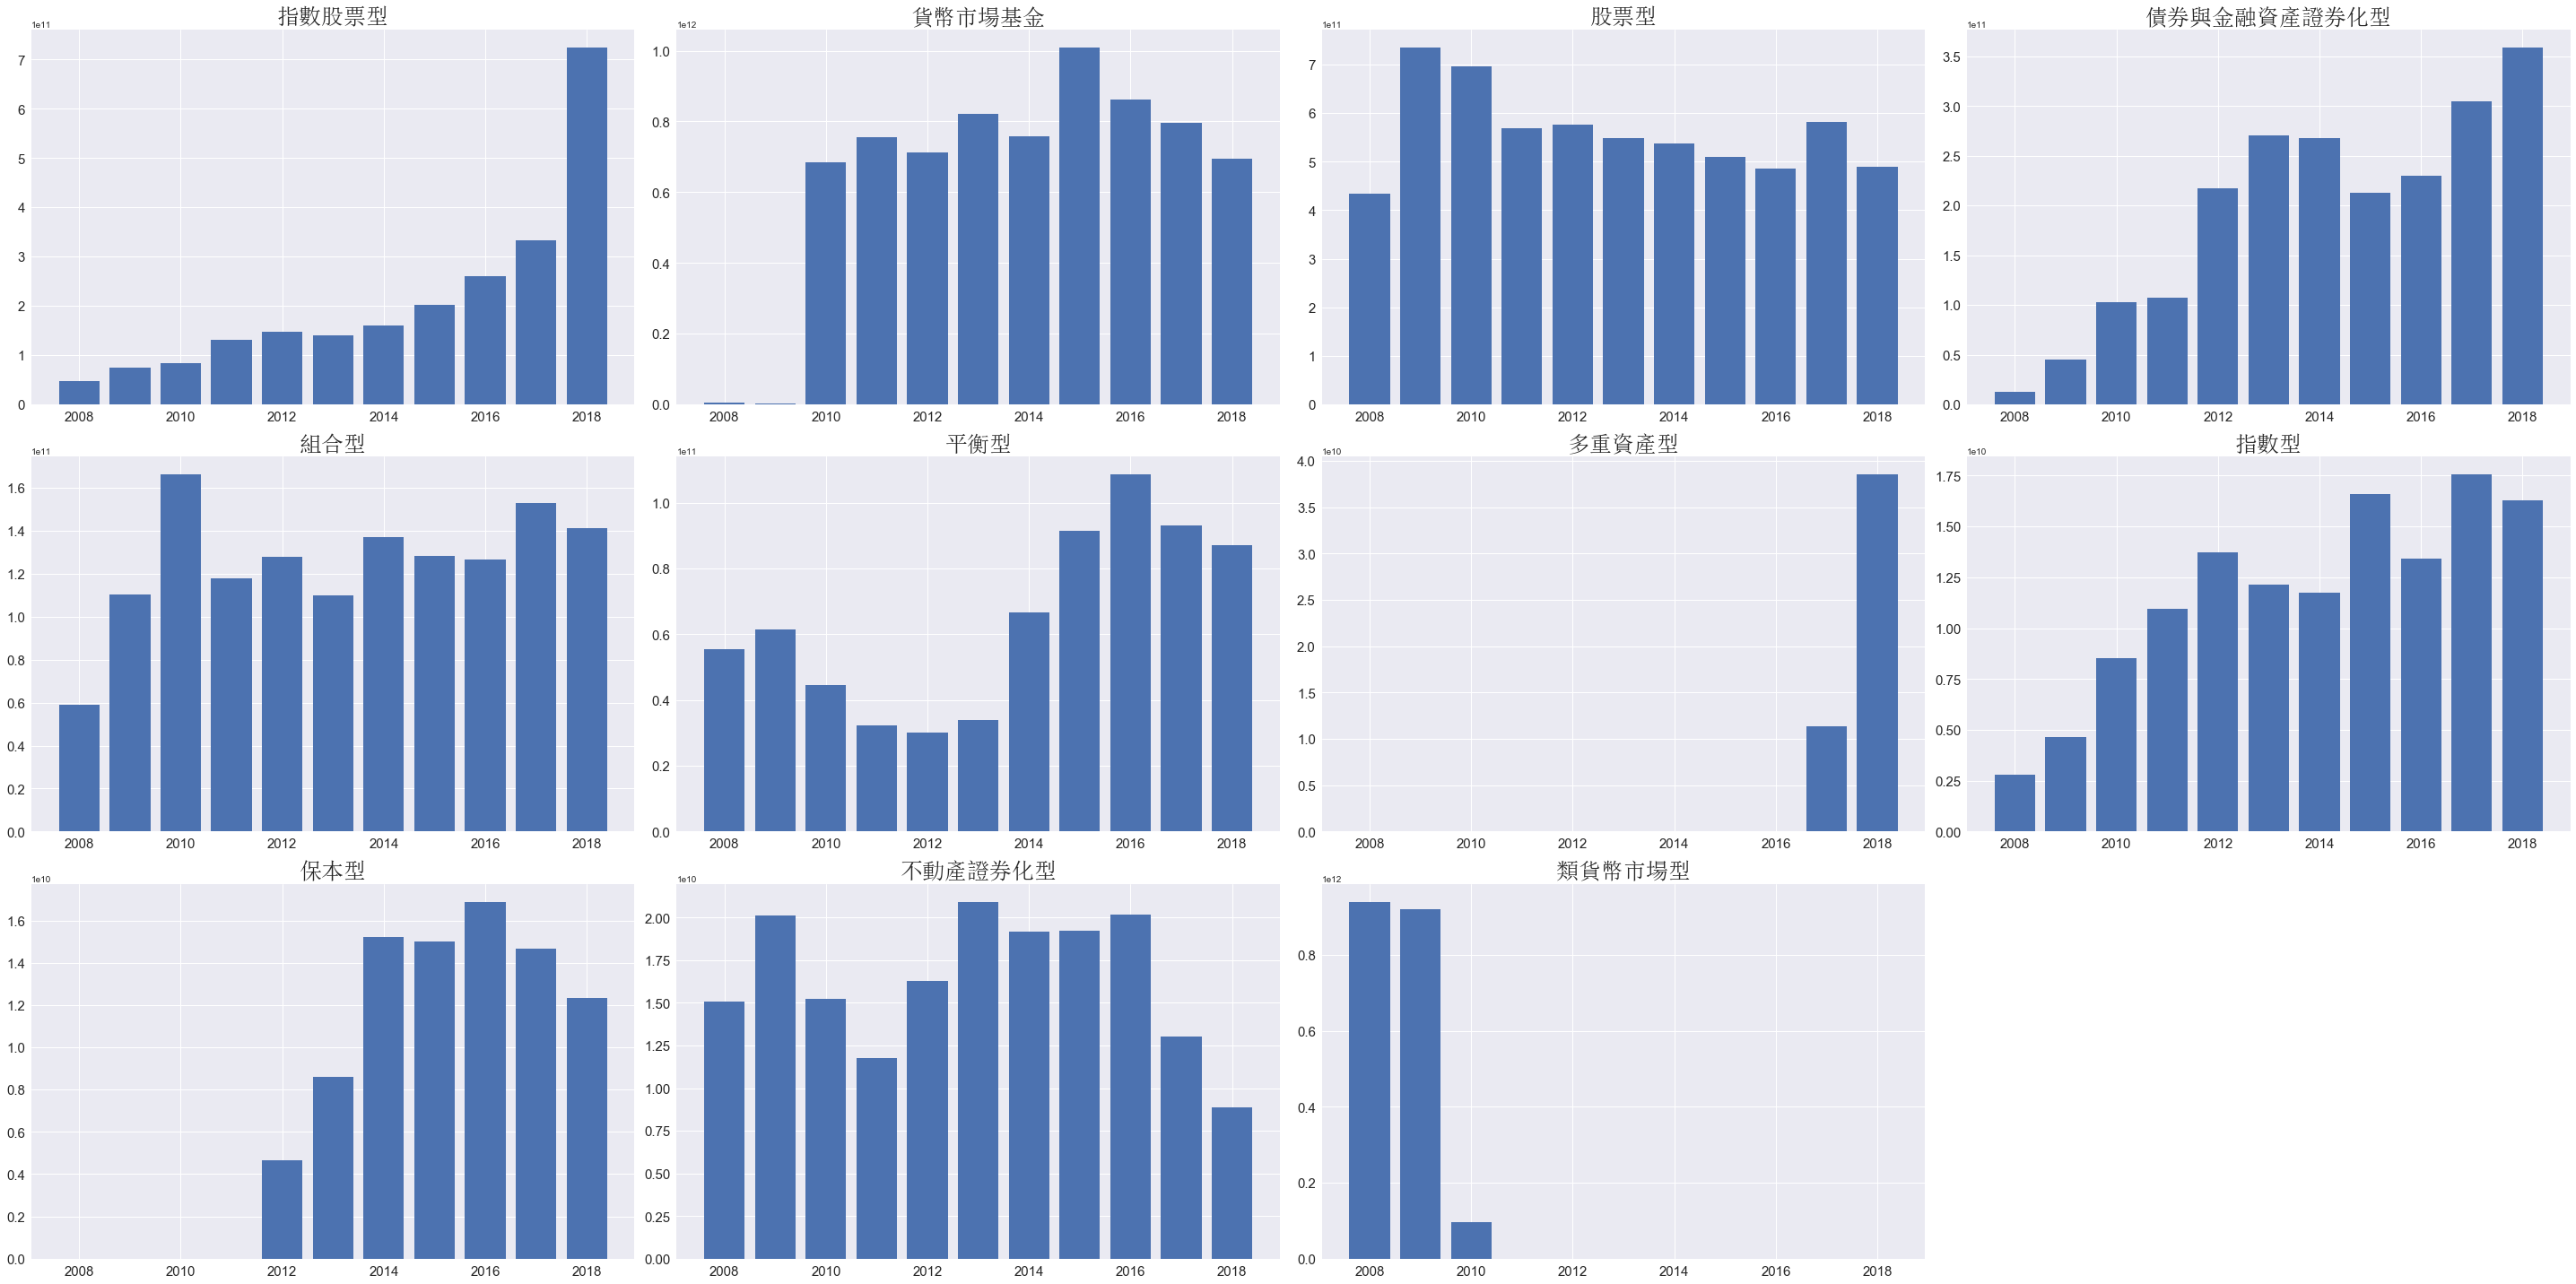

In [58]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=25)

plt.style.use('seaborn')
fig, axs = plt.subplots(3, 4, figsize=(40, 20))
axs = axs.ravel()

for i in range(len(big_category_order)):
    name = big_category_order.iloc[i]
    temp = groupby_big_category[groupby_big_category.大分類 == name]
    temp.reset_index(inplace=True, drop=True)
    temp = temp.copy()
    temp['year'] = temp.年分.apply(lambda x: x.year)
    cumulative_Y = np.array([])
    for ix in year_index:
        try:
            value = temp[temp.year == ix]['基金規模(台幣)'].values[0]
            if value != 0:
                Y.append(value)
            else:
                Y.append(0)
        except:
            Y.append(0)

    plt.sca(axs[i])
    axs[i].bar(year_index, Y)
    axs[i].set_title(name, FontProperties=font)
    plt.xticks(size=15)
    plt.yticks(size=15)
    if i == len(big_category_order) - 1:
        fig.delaxes(axs[i+1])

    plt.tight_layout();

# stack-bar plot

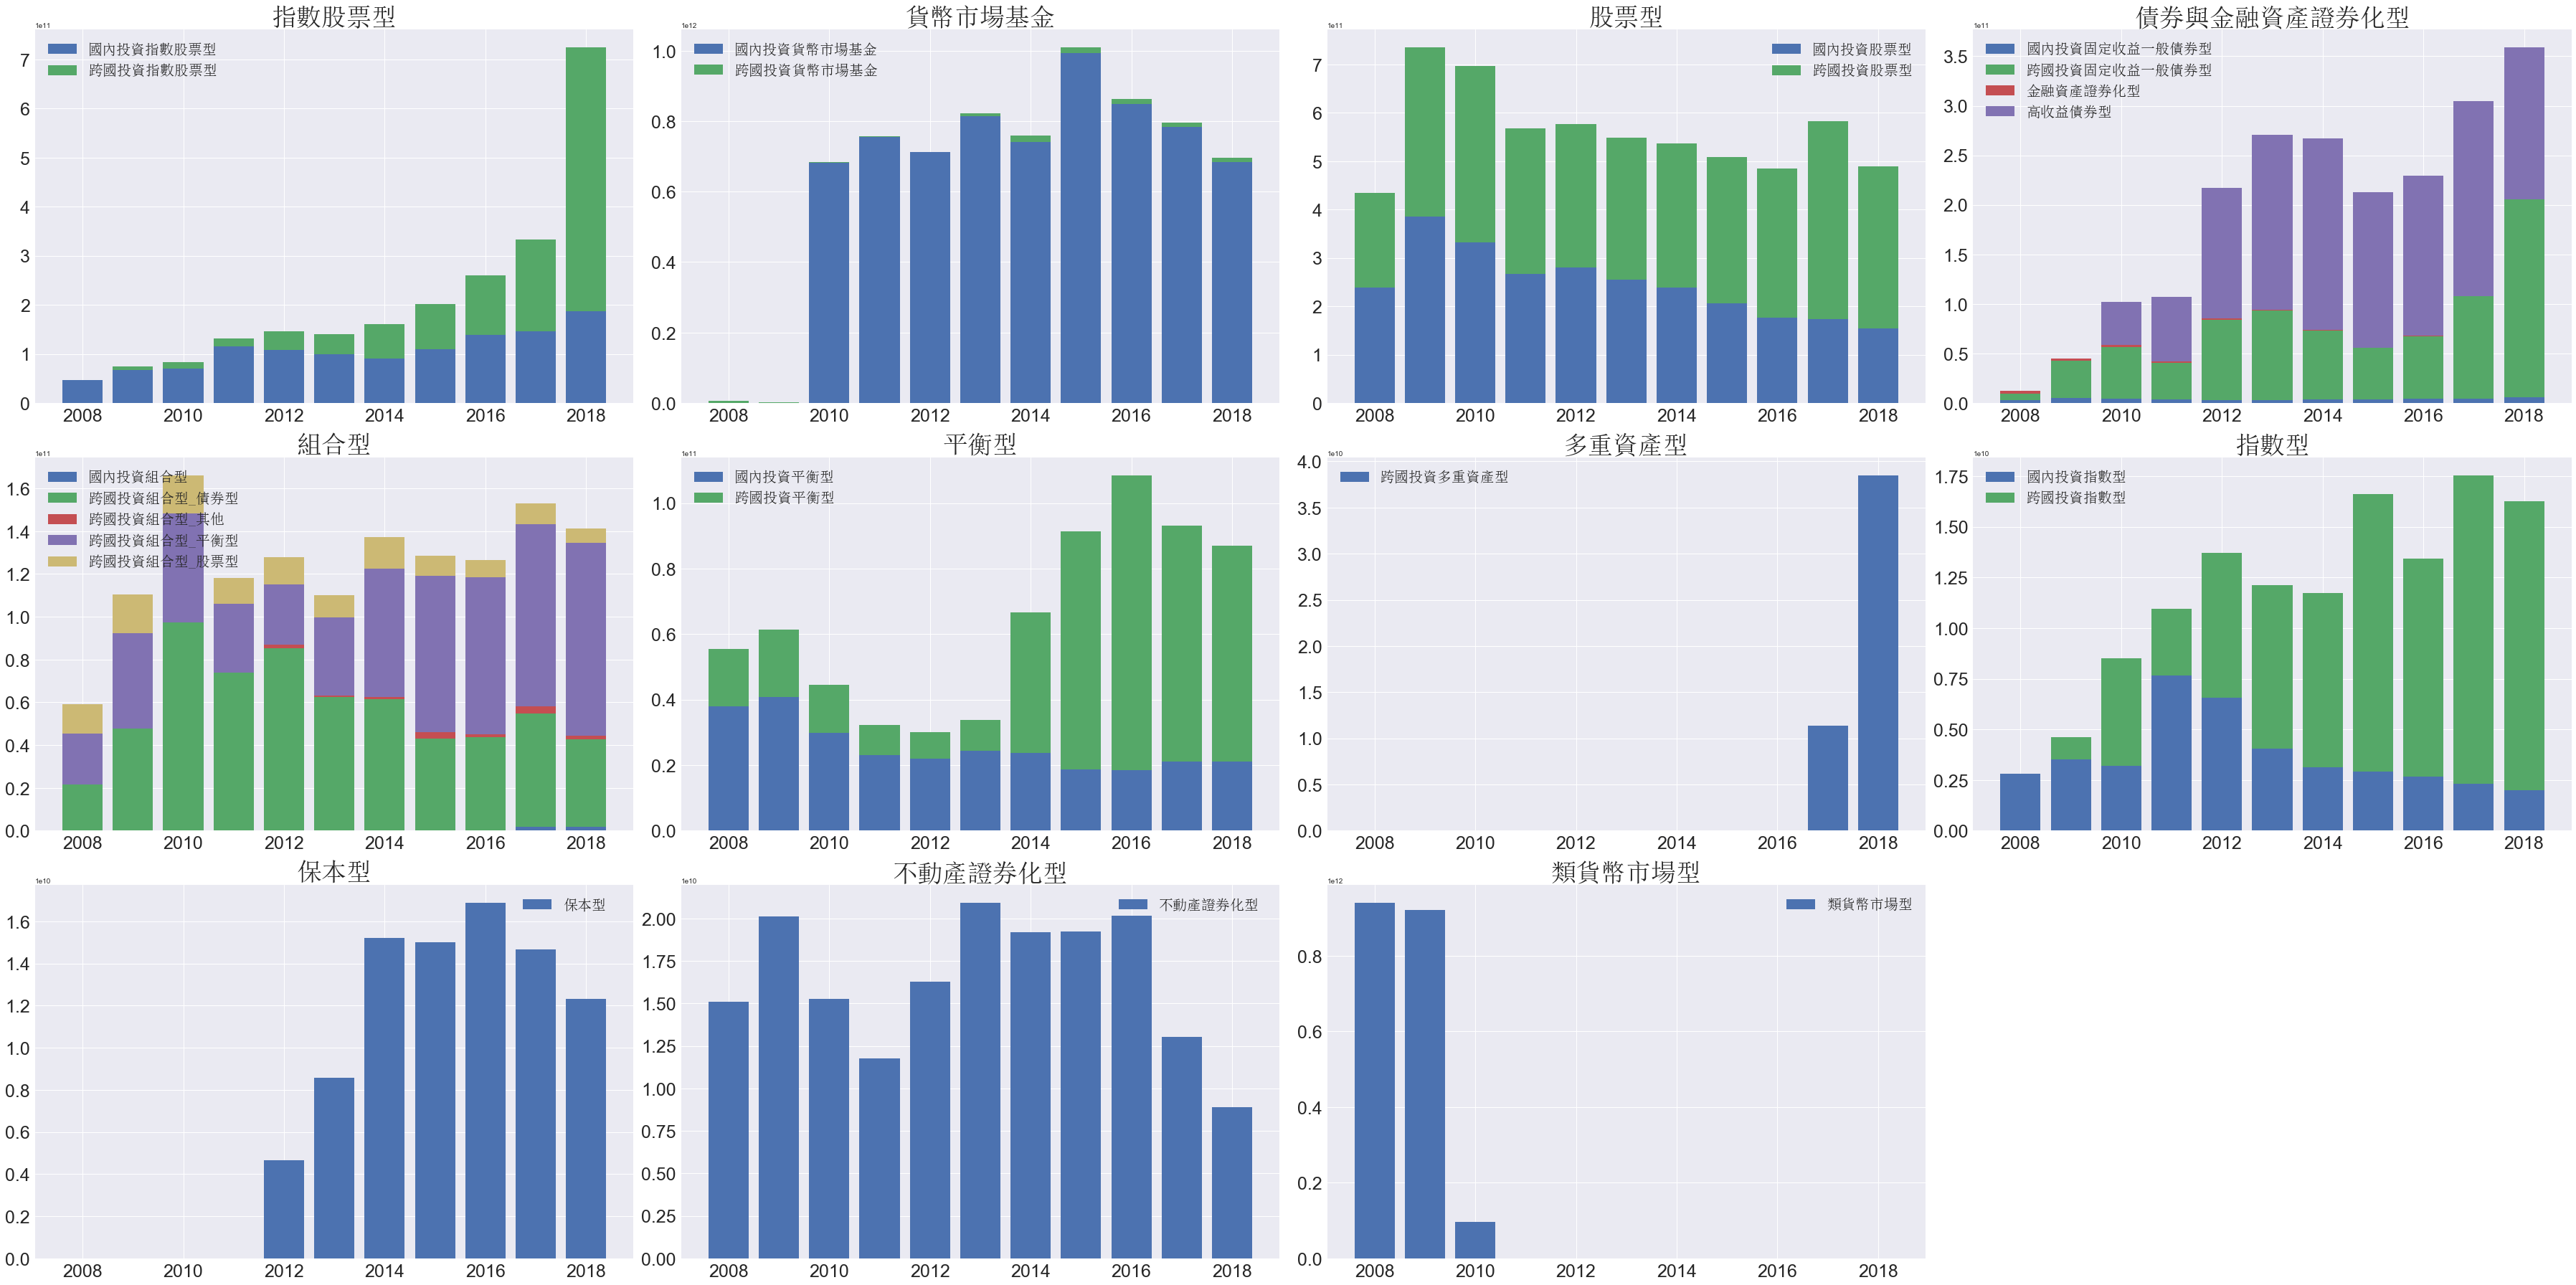

In [141]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=35)
font_legend = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=20)

plt.style.use('seaborn')
fig, axs = plt.subplots(3, 4, figsize=(50, 25))
axs = axs.ravel()

for i in range(len(big_category_order)):
    name = big_category_order.iloc[i]
#     temp = groupby_big_category[groupby_big_category.大分類 == name]
#     temp.reset_index(inplace=True, drop=True)
#     temp = temp.copy()
#     temp['year'] = temp.年分.apply(lambda x: x.year)
    
    target = data[data.大分類 == name]
    target = target.groupby(['基金類型', '年分']).sum()
    target.reset_index(inplace=True)
    target = target[['基金類型', '年分', '基金規模(台幣)']]
    plt.sca(axs[i])
    
    cumulative_Y = np.array([0]*len(year_index))
    for ixx in range(len(target.基金類型.unique())):
        fund = target.基金類型.unique()[ixx]
        temp_fund = target[target.基金類型 == fund]
        temp_fund = temp_fund.copy()
        temp_fund['year'] = temp_fund.年分.apply(lambda x: x.year)
        Y = []
        for ix in year_index:
            try:
                value = temp_fund[temp_fund.year == ix]['基金規模(台幣)'].values[0]
                if value != 0:
                    Y.append(value)
                else:
                    Y.append(0)
            except:
                Y.append(0)
        Y = np.array(Y)

        axs[i].bar(year_index, Y, bottom=cumulative_Y, label=fund)
        cumulative_Y = cumulative_Y + Y
    plt.legend(prop=font_legend)
    axs[i].set_title(name, FontProperties=font)
    plt.xticks(size=25)
    plt.yticks(size=25)
    if i == len(big_category_order) - 1:
        fig.delaxes(axs[i+1])

    plt.tight_layout();

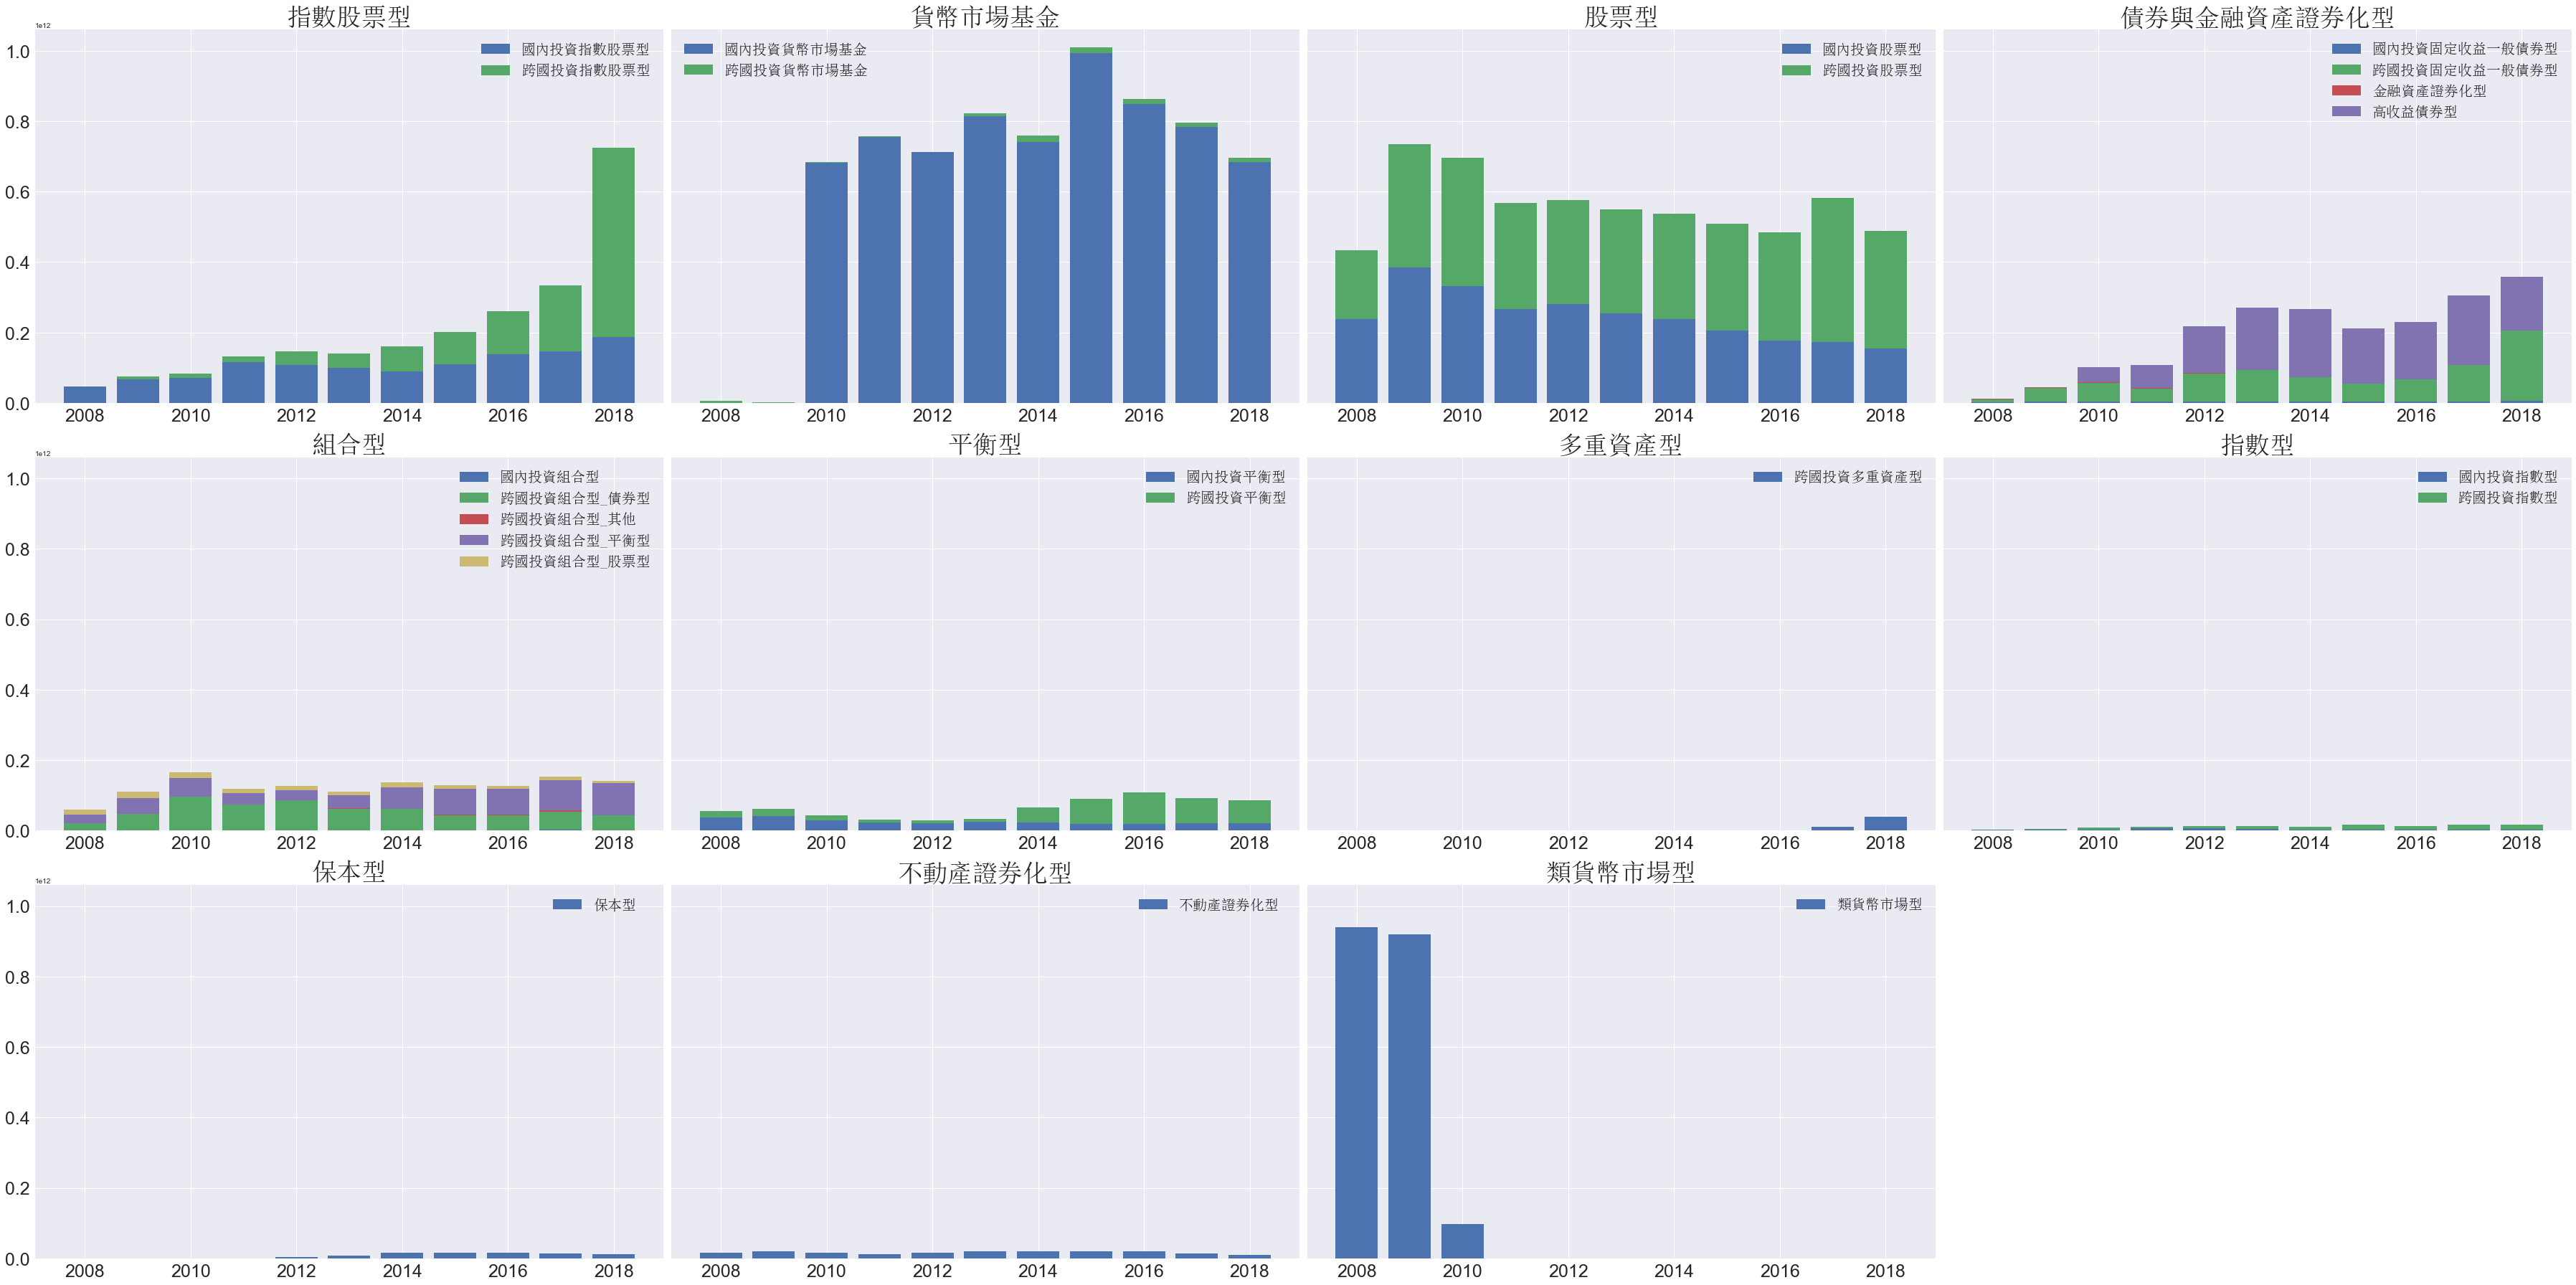

In [143]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=35)
font_legend = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=20)

plt.style.use('seaborn')
fig, axs = plt.subplots(3, 4, figsize=(50, 25), sharey=True)
axs = axs.ravel()

for i in range(len(big_category_order)):
    name = big_category_order.iloc[i]
    target = data[data.大分類 == name]
    target = target.groupby(['基金類型', '年分']).sum()
    target.reset_index(inplace=True)
    target = target[['基金類型', '年分', '基金規模(台幣)']]
    plt.sca(axs[i])
    
    cumulative_Y = np.array([0]*len(year_index))
    for ixx in range(len(target.基金類型.unique())):
        fund = target.基金類型.unique()[ixx]
        temp_fund = target[target.基金類型 == fund]
        temp_fund = temp_fund.copy()
        temp_fund['year'] = temp_fund.年分.apply(lambda x: x.year)
        Y = []
        for ix in year_index:
            try:
                value = temp_fund[temp_fund.year == ix]['基金規模(台幣)'].values[0]
                if value != 0:
                    Y.append(value)
                else:
                    Y.append(0)
            except:
                Y.append(0)
        Y = np.array(Y)

        axs[i].bar(year_index, Y, bottom=cumulative_Y, label=fund)
        cumulative_Y = cumulative_Y + Y
    plt.legend(prop=font_legend)
    axs[i].set_title(name, FontProperties=font)
    plt.xticks(size=25)
    plt.yticks(size=25)
    if i == len(big_category_order) - 1:
        fig.delaxes(axs[i+1])

    plt.tight_layout();

# 各類別(大類別)基金各年AUM概況(已依據2018年之AUM排序)，使用相同y軸scale，可以看出規模差異(幾乎看不見者代表規模相對規模大者來的小)

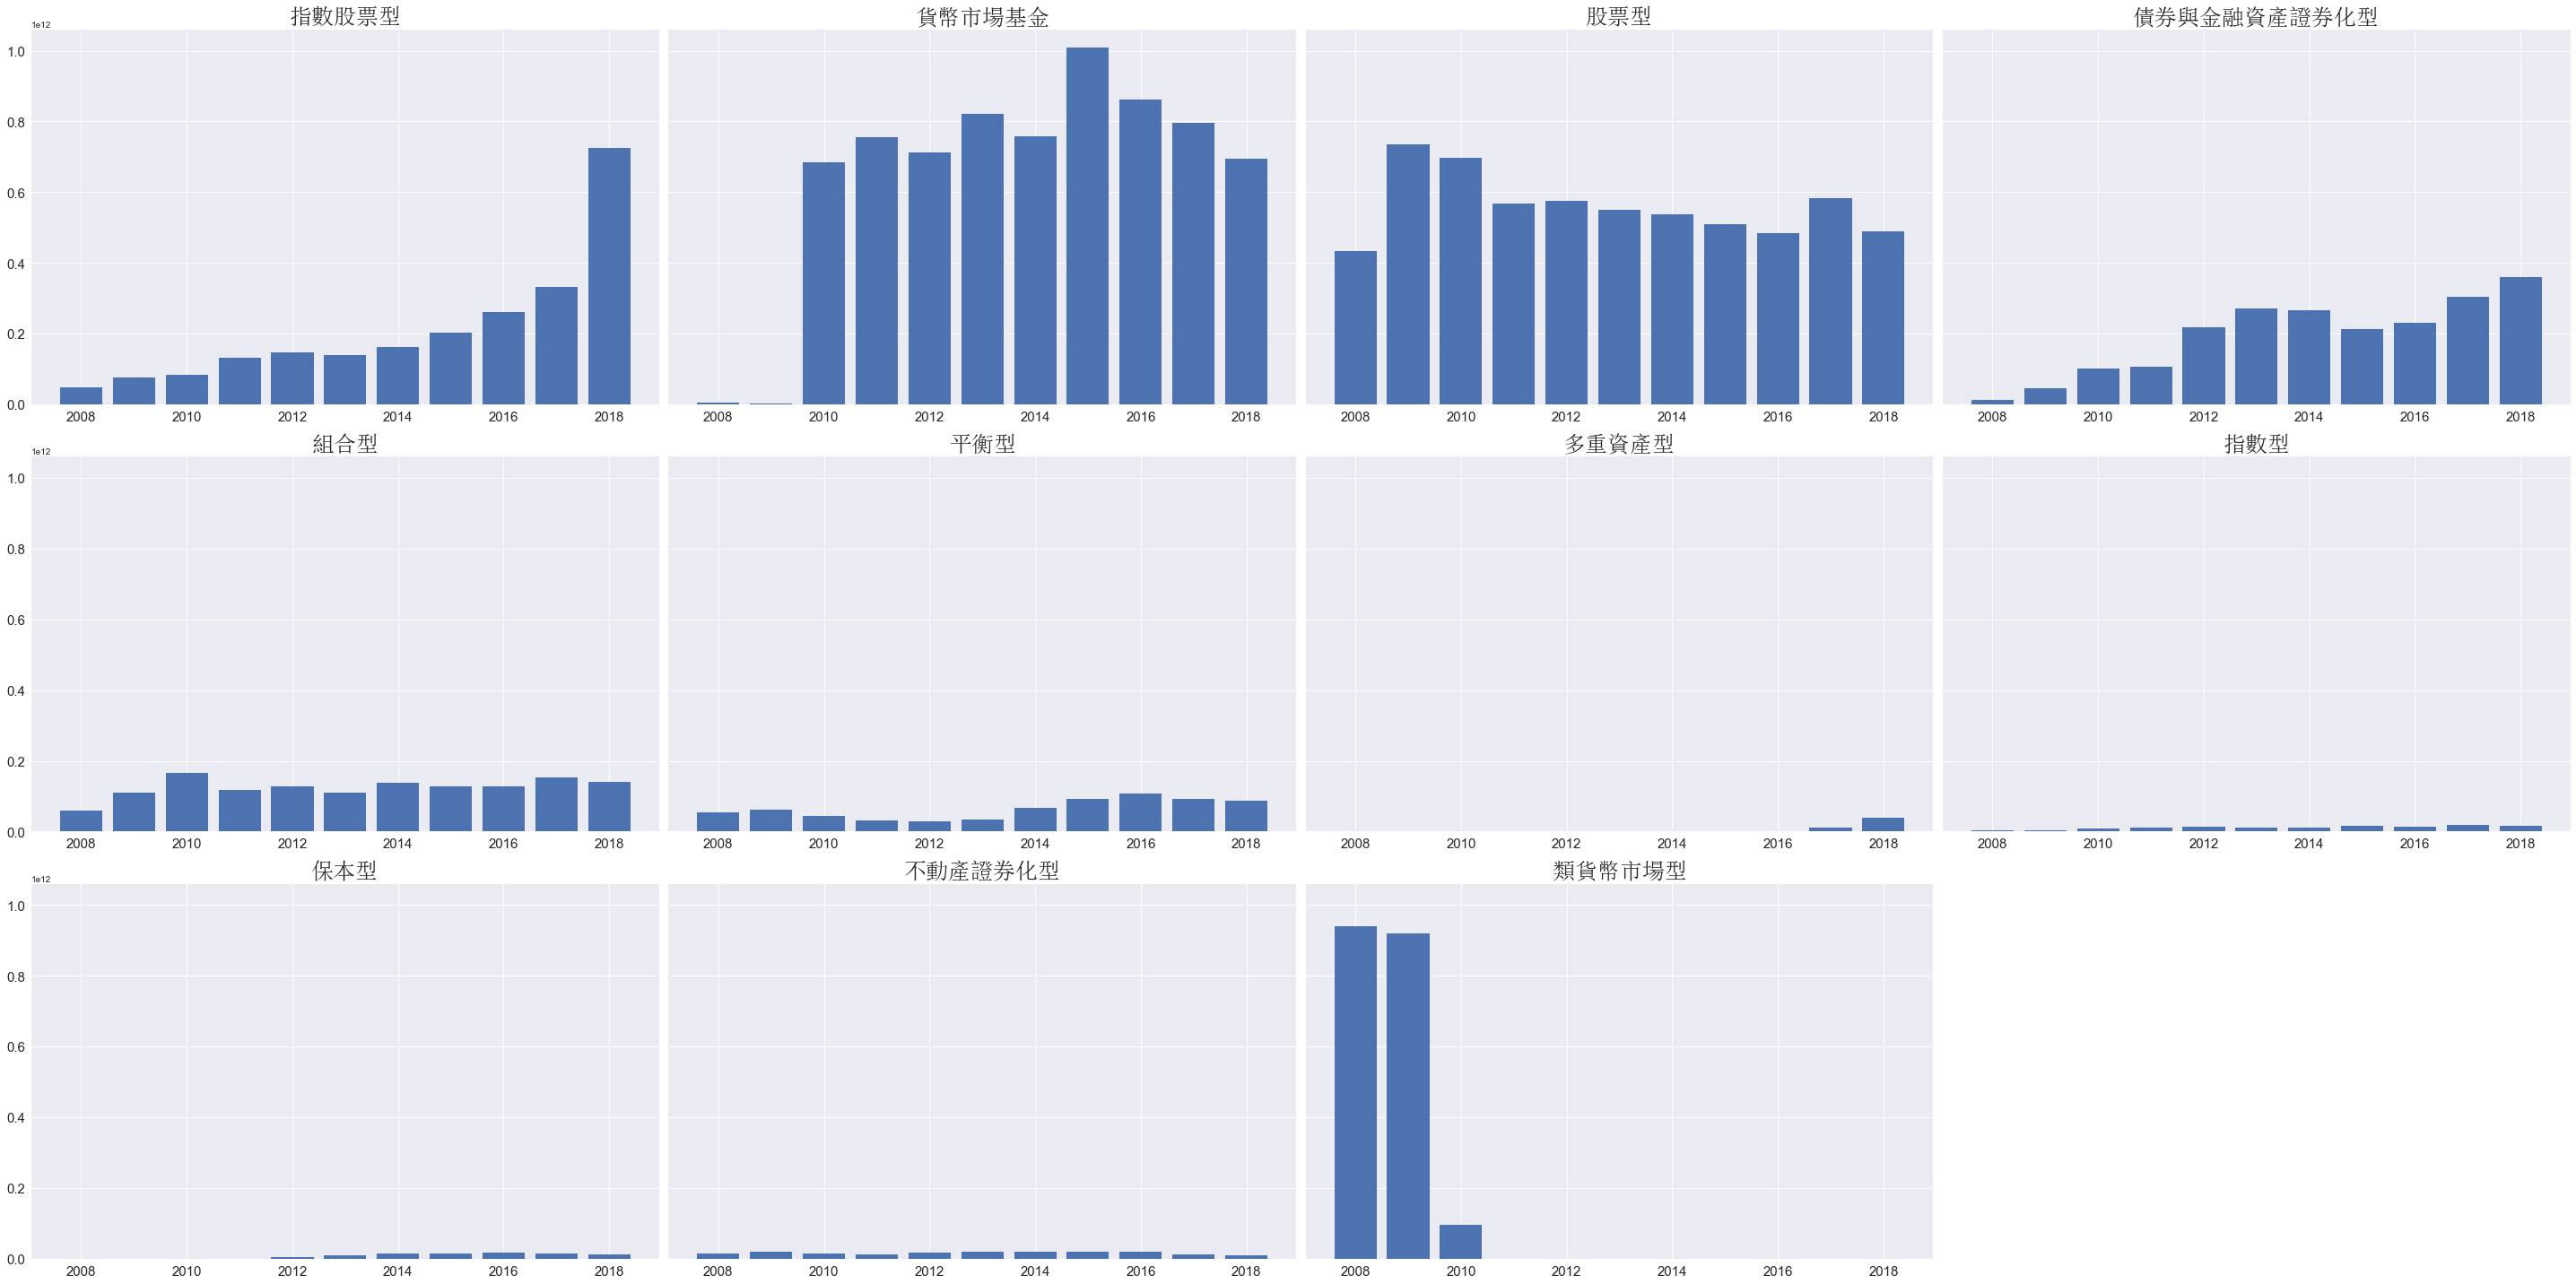

In [59]:
fig, axs = plt.subplots(3, 4, figsize=(40, 20), sharey=True)
axs = axs.ravel()

for i in range(len(big_category_order)):
    name = big_category_order.iloc[i]
    temp = groupby_big_category[groupby_big_category.大分類 == name]
    temp.reset_index(inplace=True, drop=True)
    temp = temp.copy()
    temp['year'] = temp.年分.apply(lambda x: x.year)
    Y = []
    for ix in year_index:
        try:
            value = temp[temp.year == ix]['基金規模(台幣)'].values[0]
            if value != 0:
                Y.append(value)
            else:
                Y.append(0)
        except:
            Y.append(0)

    plt.sca(axs[i])
    axs[i].bar(year_index, Y)
    axs[i].set_title(name, FontProperties=font)
    plt.xticks(size=15)
    plt.yticks(size=15)
    if i == len(big_category_order) - 1:
        fig.delaxes(axs[i+1])

    plt.tight_layout();

# 各基金類別資料筆數(細分類)

In [9]:
groupby_category = data.groupby(['類型代號', '年分']).sum()['基金規模(台幣)'].reset_index()
groupby_category.groupby('類型代號').count()

,年分,基金規模(台幣)
類型代號,,
AA1,11,11
AA2,11,11
AB1,11,11
AB2,11,11
AC11,3,3
AC12,11,11
AC21,11,11
AC22,9,9
AC23,9,9


# 各類別(小類別)基金各年AUM概況(已依據2018年之AUM排序)

In [61]:
# 依據最新資料排序市值
result = pd.DataFrame([])
for name in groupby_category.類型代號.unique():
    target = groupby_category[groupby_category.類型代號 == name].iloc[-1, :]
    if target.年分.year == 2018:
        value = target['基金規模(台幣)']
    else:
        value = 0
    temp_result = pd.DataFrame([[name, value]])
    result = pd.concat([result, temp_result])
    
result.columns = ['category', 'value']
category_order = result.sort_values('value', ascending=False)['category']

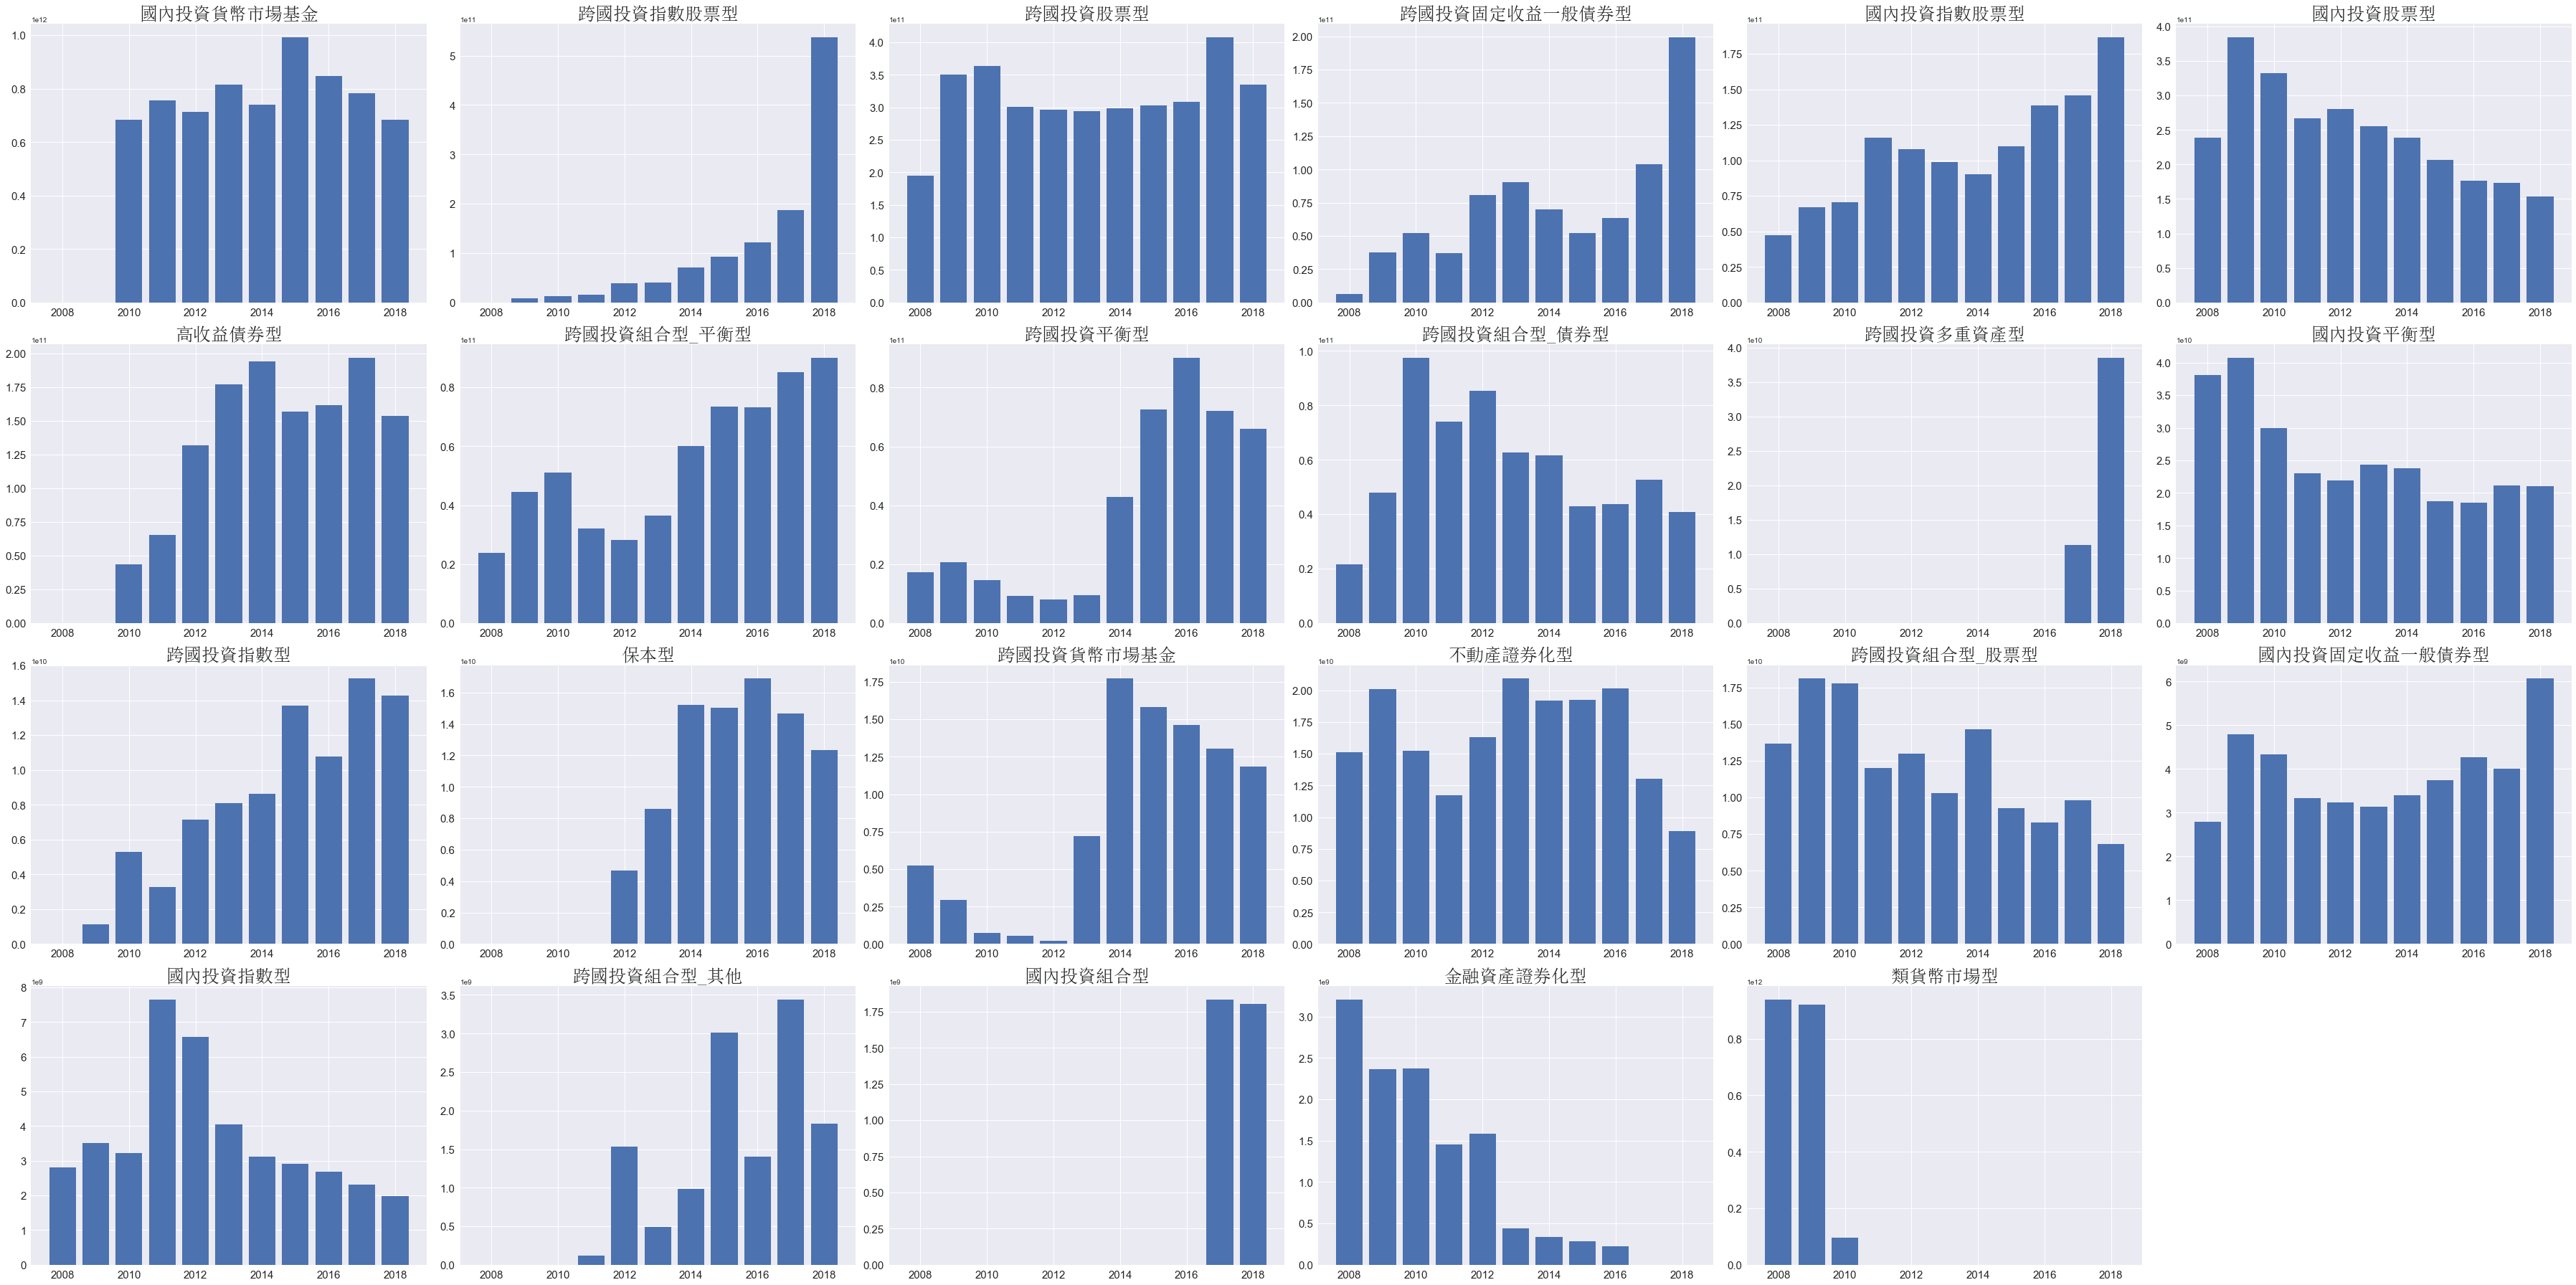

In [62]:
font = FontProperties(fname=r"c:\windows\Fonts\SimSun.ttc", size=25)

fig, axs = plt.subplots(4, 6, figsize=(50, 25))
axs = axs.ravel()

for i in range(len(category_order)):
    name = category_order.iloc[i]
    temp = groupby_category[groupby_category.類型代號 == name]
    temp.reset_index(inplace=True, drop=True)
    temp = temp.copy()
    temp['year'] = temp.年分.apply(lambda x: x.year)
    Y = []
    for ix in year_index:
        try:
            value = temp[temp.year == ix]['基金規模(台幣)'].values[0]
            if value != 0:
                Y.append(value)
            else:
                Y.append(0)
        except:
            Y.append(0)

    axs[i].bar(year_index, Y)
    axs[i].set_title(category_dict[name], FontProperties=font)
    plt.sca(axs[i])
    plt.xticks(size=15)
    plt.yticks(size=15)
    if i == len(category_order) - 1:
        fig.delaxes(axs[i+1])

    plt.tight_layout();

# Reference
* https://stackoverflow.com/questions/17210646/python-subplot-within-a-loop-first-panel-appears-in-wrong-position
* https://stackoverflow.com/questions/14694501/delete-a-subplot